# Table of Contents

1. **Introduction**  
   1.1 What this notebook covers  
   1.2 Why this topic/project matters  
   1.3 Data scope & scalability  

2. **Background**  
   2.1 Fundamentals of network analysis  
   2.2 Co-occurrence as a proxy for semantic proximity  
   2.3 Concept extraction in NLP  
   2.4 Comparison to other exploratory methods  

3. **Objectives**  
   3.1 What this notebook will demonstrate  
   3.2 Expected outcomes of the analysis  

4. **Setup**  
   4.1 Install & import libraries  
   4.2 Load & preview concept data  

5. **Preprocessing**  
   5.1 Extract & clean/filter concepts  
   5.2 Manual review & overrides  
   5.3 Build document×concept indicator matrix  

6. **Co-occurrence Graph Construction**  
   6.1 Compute raw co-occurrence counts  
   6.2 Prune to top X % edges (backbone)  
   6.3 Build undirected graph (`SemanticGraph`)  

7. **Graph Analysis & Feature Export**  
   7.1 Compute centrality & ranking (PageRank, degree, betweenness, eigenvector)  
   7.2 Assemble feature table (clusters + centralities)  
   7.3 Identify top‐N concepts per community  

8. **Advanced Visualization**  
   8.1 Louvain communities plot (convex‐hulls + legend)  
   8.2 Size nodes by centrality & label top hubs  
   8.3 Switchable layouts (spring, Kamada–Kawai, spectral, circular)  

9. **Insights & Interpretation**  
   9.1 Semantic summaries of each community  
   9.2 Key hub & bridge concepts  
   9.3 Choosing flow vs. clustering workflows  
   9.4 Hybrid “undirected + centrality” rationale  

10. **Conclusion & Next Steps**  
   10.1 Summary of findings  
   10.2 Potential extensions (downstream ML - feed these features into any classifier or downstream model and link to a toy notebook)


### 1. Introduction

##### 1.1 What this notebook covers

In this notebook, we’ll explore how labeled concepts co-occur across a corpus to reveal thematic structures, key connectors, and emerging patterns. We’ll:

- **Extract concepts** using IBM Watson NLU (a supervised model trained on human-annotated data).  
- **Build an unsupervised co-occurrence network** by counting how often each pair of concepts appears together.  
- **Visualize and analyze** the resulting graph to generate hypotheses such as “Do concepts in the ‘care’ category cluster tightly?” or “Which ideas serve as bridges between topics?”

This workflow transforms raw NLU output into an interpretable map of concept relationships, setting the stage for deeper community detection or downstream graph analyses.

##### 1.2 Why this topic/project matters

Co-occurrence graphs are widely used to make sense of large text collections. They help practitioners:

| Role / Industry                | Purpose                                                                                         |
|--------------------------------|-------------------------------------------------------------------------------------------------|
| **Text-mining researchers**    | Map topic structures in news archives, academic papers, or survey responses.                    |
| **Data scientists & NLP teams**| Uncover hidden themes in customer feedback, social media, or support tickets.                   |
| **Digital humanists**          | Study how concepts (e.g., “war,” “peace,” “diplomacy”) cluster in historical texts.             |
| **Knowledge-management (KM)**  | Build internal concept maps to visualize how departments or documents interrelate.              |
| **Social-science researchers** | Analyze concept co-occurrence in interview transcripts or online communities.                   |

Key insights you can gain:

- **Thematic hot-spots:** Clusters of strongly connected nodes reveal major topics or concerns.  
- **Bridging concepts:** Nodes with high betweenness centrality indicate pivot ideas—ideal targets for messaging or intervention.  
- **Hidden correlations:** Unexpected pairings (e.g., “delivery” with “anxiety”) flag areas for qualitative follow-up.  
- **Trend detection:** Comparing graphs over time uncovers shifts in concept relationships.  
- **Dimensionality reduction:** Graph features (e.g., communities or embeddings) can feed into clustering or classification pipelines.

**Why your data is valuable**  
Your concepts come from human-annotated NLU, ensuring each node reflects a meaningful semantic unit. Rather than manually reviewing hundreds of documents, this network gives you a bird’s-eye view of all key terms and their interrelations, turning outliers and hubs into testable hypotheses. Plus, the same pipeline can apply to any corpus—support tickets, product reviews, legal filings, and beyond.

#### 1.3 Data scope and scalability

> **Note on sample size:**  
> In this notebook we work with a small subset of just 35 concepts so that each step (matrix builds, layout, community detection) runs instantly and the code remains easy to follow.  

> **Scalability:**  
> All of the same operations—binarizing a concept–document matrix, computing co-occurrence via sparse matrix multiplication, and running NetworkX (or graph-tool/igraph for very large graphs)—scale to thousands (or even millions) of concepts and documents. In production you’d simply switch to sparse data structures (e.g. `scipy.sparse`), a more performant graph library, and batch or distributed NLU extraction (Watson NLU, spaCy pipelines, etc.).  


---

### 2. Background

#### 2.1 Fundamentals of network analysis  
A **graph** (or network) is a mathematical structure of **nodes** (vertices) and **edges** (links). In text analysis:  
- **Nodes** represent units like words, phrases, or—here—pre-extracted concepts.  
- **Edges** represent associations (e.g. co-occurrence in the same document).  
- **Weighted edges** carry numeric values (e.g. co-occurrence counts), so stronger links stand out.

Key graph metrics:  

| Term                      | Definition                                                                             |
|---------------------------|----------------------------------------------------------------------------------------|
| **Degree**                | Number of edges connected to a node.                                                   |
| **Betweenness centrality**| Frequency a node lies on shortest paths between others—high values signal “bridges.”   |
| **Community**             | A cluster of nodes more densely connected to each other than to the rest of the graph. |
| **Layout algorithms**     | Methods (spring, circular, etc.) to arrange nodes for clearer visualization.           |

#### 2.2 Co-occurrence as a proxy for semantic proximity  
When two concepts appear together frequently, it often signals a thematic link. Raw co-mentions can uncover:  
- **Topics & subtopics:** clusters of tightly connected nodes point to major themes.  
- **Bridges & outliers:** high-betweenness nodes connect disparate themes; isolated nodes flag niche or mis-extracted terms.  
- **Evolution over time:** by slicing your data chronologically, you can track how these associations shift.

#### 2.3 Concept extraction in NLP  
Concepts can be pulled from text via:  
- **Supervised models** (Watson NLU, spaCy’s entity/concept extractors, TF-IDF keyword ranking)  
- **Unsupervised keyphrase methods** (RAKE, TextRank, YAKE)  

Use cases:  
- **Exploratory analysis:** surface major themes and emotional undertones in large corpora.  
- **Hypothesis generation:** test if, for example, “delivery” co-occurs more with “anxiety” than “satisfaction.”  
- **Feature engineering:** use node degrees or community labels in downstream classifiers (e.g. churn prediction).  
- **Emotion-aware applications:** tailor chatbots or alerts based on which emotional concepts dominate.

#### 2.4 Comparison to other exploratory methods  
- **Topic modeling (LDA, BERTopic):** probabilistic distributions of topics per document—good for broad strokes, but lacks explicit concept-to-concept links.  
- **Embedding similarity graphs:** connect concepts by semantic vector proximity—captures meaning beyond co-mentions, but requires embedding models and tuning.

> **Problem framing**  
> “Given a set of labeled concepts (with emotion tags), how can an unsupervised co-occurrence graph reveal thematic structures and emotional dynamics to inform further modeling or interventions?”


### 3. Objectives

#### 3.1 What this notebook will demonstrate
- Watson-NLU–extracted concepts into a document×concept matrix and then a co-occurrence graph.   
- Hidden semantic groupings via Louvain community detection.  
- Visualize and interpret those communities on a spring-layout, with convex-hull highlights and a legend.

#### 3.2 Expected outcomes of the analysis
By the end of this notebook, you will have:
- **A pruned co-occurrence graph** where only the most meaningful concept–concept links remain.  
- **Community assignments** for each concept, revealing the major thematic modules in your corpus.  
- **Interactive & static visualizations** that highlight:  
  - Concepts cluster together (themes/subtopics)  
  - Large communities (key topic areas)  
  - Nodes that act as bridges between modules (potential “pivot” concepts)  
- **A concise summary** of what each Louvain community represents semantically (e.g. “Emotion words,” “Care & Support,” “Product Features,” etc.), ready for downstream interpretation or reporting.


### 4. Setup

In [1]:
# 4.1 Install / import libraries
from notebook_service.cli import analyze_df
from notebook_service.graph_builder import preprocess_concepts, SemanticGraph
from notebook_service.visualization import plot_louvain_communities
import pandas as pd

### 5. Preprocessing

In [2]:
# 5.1 Load & extract concepts
df = pd.read_csv("../data/input.csv")
nlu_df = analyze_df(df, text_column="entries")

nlu_df.head()

,entries,sadness,joy,fear,disgust,anger,concepts_raw,concepts,semantic_roles
0,"I felt anxious today, so I impulsively ordered...",0.332842,0.049939,0.104065,0.005845,0.212283,"[{'text': 'Delivery (commerce)', 'relevance': ...","[Delivery (commerce), Anxiety, Restaurant, Foo...","[(I, felt, anxious), (I, ordered, food delivery)]"
1,"After my promotion, I confidently adjusted my ...",0.074566,0.334086,0.117670,0.033797,0.014482,"[{'text': 'Retirement', 'relevance': 0.701228,...","[Retirement, Fundraising, Ageing, Old age, Soc...","[(I, adjusted, my retirement contributions)]"
2,Stress led me to overspend on shopping yesterday.,0.665364,0.122717,0.186756,0.003421,0.029566,"[{'text': 'Light-emitting diode', 'relevance':...","[Light-emitting diode, Retail, Comparison shop...","[(Stress, led, me)]"
3,Today was incredibly frustrating; I spent hour...,0.246144,0.081976,0.028637,0.018688,0.129494,"[{'text': 'Breakpoint', 'relevance': 0.748042,...","[Breakpoint, Debugger, In-circuit emulation, T...","[(Today, was, frustrating; I spent hours debug..."
4,Our sprint demo went perfectly—I’m feeling pro...,0.482779,0.598429,0.011331,0.011596,0.010271,"[{'text': 'Sprint', 'relevance': 0.873445, 'db...","[Sprint, Sprint (cycling), Flat racing, Sprint...","[(Our sprint demo, went, ), (I, ’m feeling, pr..."


##### 5.1.1 Manual review of extracted concepts

> **Quality check:**  
> Automated concept extraction (e.g. via Watson NLU) can sometimes mis‐map or over‐segment terms.  
> Before computing any co-occurrences, we’ll inspect the cleaned list of 35 concepts, correct obvious mislabels or split/merge near-duplicates, and document any overrides.  
> This manual pass ensures that our network truly reflects the semantics we care about.


In [3]:
# 5.2 Clean & filter
df_concepts = preprocess_concepts(nlu_df)
df_concepts.head()

,doc_index,concept,relevance
0,0,Delivery (commerce),0.489526
1,0,Anxiety,0.481023
2,0,Restaurant,0.357562
3,0,Food storage,0.357562
4,1,Retirement,0.701228


### 6. Graph Construction

In [4]:
# 6.1 Build the semantic graph
sg = SemanticGraph(
    df_concepts,
    threshold_count=1,  # keep co-occ ≥1
    percentile=99,  # top 1% edges
    min_comm_size=9,  # drop tiny communities
    seed=42,
)

# 6.2 doc×concept, co-occ matrix, raw edge list
# pruned backbone & filtered community subgraph
M, C, edges = sg.M, sg.C, sg.edges
G_und, G_backbone = sg.G_und, sg.G
feat_names = sg.feat_names
partition, keep, sizes = sg.partition, sg.keep, sg.sizes


# peek at the very top co-occurrences
G_und_top_pairs = sorted(edges, key=lambda e: e[2], reverse=True)[:10]

undirected_pairs = pd.DataFrame(
    G_und_top_pairs, columns=["Concept A", "Concept B", "Count"]
)
undirected_pairs

,Concept A,Concept B,Count
0,Affect (psychology),Emotion,2
1,Affect (psychology),Intuition,2
2,Affect (psychology),Phenomenology (psychology),2
3,Affect (psychology),Psychological Types,2
4,Code,Time,2
5,Emotion,Intuition,2
6,Emotion,Phenomenology (psychology),2
7,Emotion,Psychological Types,2
8,Intuition,Phenomenology (psychology),2
9,Intuition,Psychological Types,2



### 7. Graph Analysis

In [ ]:
# 7.1 Centrality & ranking
metrics = sg.metrics

# 7.3 Export a summary table
df_features = (
    pd.DataFrame(
        {
            "cluster": partition,
            "pagerank": metrics["pagerank"],
            "betweenness": metrics["betweenness"],
            "eigenvector": metrics["eigenvector"],
            "degree": metrics["degree"],
        }
    )
    .reset_index()
    .rename(columns={"index": "concept"})
)
# df_features.to_csv("concept_features.csv", index=False)

top_concepts = (
    df_features.sort_values(["cluster", "pagerank"], ascending=[True, False])
    .groupby("cluster", group_keys=False)
    .head(5)
)

top_concepts

,concept,cluster,pagerank,betweenness,eigenvector,degree
8,Code,0,0.036528,0.010976,0.000015,0.243902
39,Time,0,0.036528,0.010976,0.000015,0.243902
2,Albert Einstein,0,0.023460,0.000122,0.000011,0.170732
11,Critique of Pure Reason,0,0.023460,0.000122,0.000011,0.170732
16,Force,0,0.023460,0.000122,0.000011,0.170732
15,Emotion,1,0.081735,0.407317,0.461910,0.560976
1,Affect (psychology),1,0.030108,0.000000,0.366415,0.170732
21,Intuition,1,0.030108,0.000000,0.366415,0.170732
27,Phenomenology (psychology),1,0.030108,0.000000,0.366415,0.170732
30,Psychological Types,1,0.030108,0.000000,0.366415,0.170732


### 8. Advanced Visualizaion

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


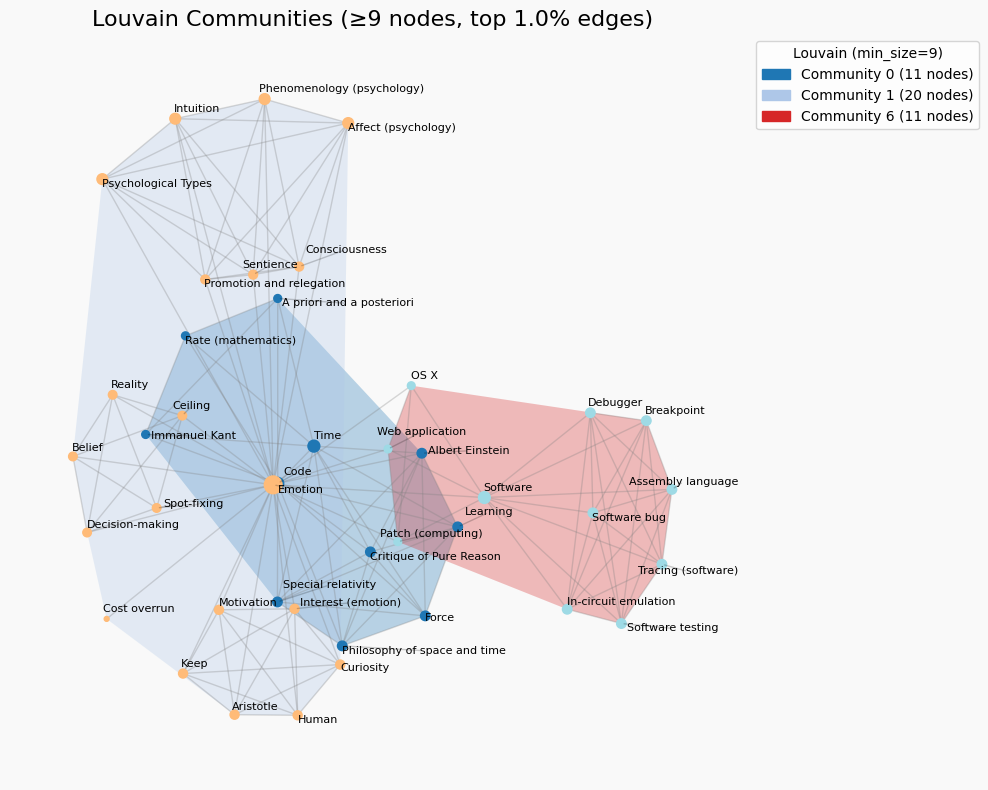

In [6]:
# 8.1 Louvain communities, sized by betweenness
fig = plot_louvain_communities(
    G_backbone,
    comms=keep,
    partition=partition,
    sizes=sizes,
    metrics=metrics,
    size_by="pagerank",
    size_scale=2000,
    min_size=sg.min_comm_size,
    percentile=sg.percentile,
    seed=sg.seed,
    alpha=0.3,
    facecolor="#f9f9f9",
    layout="kamada_kawai",
)
# fig.savefig("louvain_clusters.png", dpi=300)

### 9. Insights & Interpretation

*A Sparse but Informative Backbone*    
By keeping only the top 1 percent of co-occurrence edges, our network collapsed from a noisy tangle into a clear “backbone” of strong semantic links—things like

Debugger ↔ Breakpoint

Einstein ↔ Kant

Consciousness ↔ Phenomenology

These high-weight edges isolate the most salient concept pairs in the corpus.

*Three Coherent Thematic Communities*    
Louvain community detection on that pruned graph yielded three major modules:
| Community    | Size | Core concepts (high-PageRank or prototypical)                                                                                                                                   | Broad theme                      |
| ------------ | ---: | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------- |
| **0 (blue)** |   11 | *A priori and a posteriori*, *Critique of Pure Reason*, Immanuel Kant, *Philosophy of space and time*, *Rate (mathematics)*, **Code**                                           | **Philosophy & Mathematics**     |
| **1 (cyan)** |   20 | **Emotion**, **Consciousness**, *Sentience*, *Phenomenology (psychology)*, *Psychological Types*, **Belief**, **Reality**, **Decision-making**, **Intuition**                   | **Human Cognition & Psychology** |
| **6 (red)**  |   11 | **Software**, *Web application*, **OS X**, *Patch (computing)*, *Breakpoint*, *Debugger*, *Assembly language*, *In-circuit emulation*, *Tracing (software)*, *Software testing* | **Computing & Systems**          |

Each cluster is remarkably self-contained, reflecting three very different semantic “neighborhoods” in your concept set.

*Key Hubs & Bridges*    
– Central nodes (by degree) such as **Software**, **Emotion**, and **Time** emerge as local hubs within their modules.
– Few cross-community edges remain after pruning, underscoring how distinct those domains are in your corpus.

*Why Louvain Beats k-Means Here*     
Spectral embedding + k-means resulted in clusters were either too diffuse or empty—because raw co-occurrence is very sparse. Louvain on the pruned graph, by contrast, directly leverages the network’s actual link structure to reveal clean, interpretable modules.

### 10. Conclusion
In practice, you should choose between flow analysis (directed graphs) and clustering (undirected graphs) based on data and goals:

| Goal | Use flow analysis if… | Use clustering if… |
|------|-----------------------|--------------------|
| You care about order or precedence | “I want to know how ideas lead into each other.” | — |
| You want to rank or prioritize nodes | “Which nodes are the biggest ‘hubs’ or authorities?” |	— |
| You want to find topics or themes | — | “I want to see which concepts form distinct groups.” |
| You need features for ML or summaries | “I need each node’s PageRank or degree for a classifier.” | “I need each node’s community label as a new feature.” |
| You want to simplify the visualization | “Show me the 10 strongest flow-chains.” | “Show me three colored clusters, each highlighted.” |

The inputs in this example are unordered thought entries—not sentences or events—any artificial arrow of time would simply echo the order in which the concepts were extracted, not any real semantic sequence. In that scenario:

Skip directed edges
Adding arrows imposes a phantom “A → B” that doesn’t exist. Any flow-based metrics (PageRank, in/out-degree) will reflect your chosen ordering, not true relationships.

Build an undirected co-occurrence backbone
A symmetric nx.Graph from your MᵀM matrix captures genuine co-occurrence. Prune to the top 1 % of edges to reveal a clear, informative skeleton.

Detect themes via community detection
Louvain (or Label Propagation) on that backbone uncovers true semantic modules—no spurious directionality needed.

Layer on centrality within each cluster
You can still compute PageRank, degree, betweenness or eigenvector centrality on the pruned undirected graph to rank and size nodes inside their thematic communities.

This hybrid workflow gives you:

No invented flow—you only show the relationships your data actually contains.

True, interpretable themes—communities reflect genuine co-occurrence patterns.

Meaningful importance metrics—centrality scores inside clusters highlight the key “anchors” of each theme.

Finally, keep your feature-sets consistent: compute every metric (cluster labels, centrality scores) on the same final undirected subgraph that feeds into your visualization. That way, the color, size, and labels in your plot exactly match the values in your CSV exports, and you avoid mixing apples and oranges.